In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
PATH = os.path.join("..\\worldcup", "7556.json")
LABELS = ['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'off_camera', 'team', 'player', 'position', 'location', 'duration', 'under_pressure', 'related_events', 'pass']
TO_DROP = ["id", 'index', 'period', 'timestamp', 'second', 'possession', 'off_camera']

with open(PATH, encoding="utf-8") as json_file:
    data = json.load(json_file)
    
compositions = data[:2]
events = data[2:]

In [31]:
def refine(dic) -> list:
    res = []
    for label in LABELS:
        if label in dic.keys():
            res.append(dic[label])
        else:
            res.append(None)
    return res

def clean_list(events) -> list:
    ##### USE THIS #####
    res = []
    for e in events[2:]:
        res.append(refine(e))
    return res

def clean_df(df):
    columns=["type", "possession_team", "play_pattern", "team", "player", "position"]
    for c in columns:
        df[c] = df[c].apply(lambda x : None if x is None else x["name"] )
        
def get_df():
    df = pd.DataFrame(clean_list(events), columns=LABELS)
    clean_df(df)
    df = create_data_pass(df)
    df = df.drop(columns=TO_DROP)
    return df
        
        
def create_data_pass(passes) -> pd.DataFrame: 
    columns = ["recipient", "length", "angle", "height", "end_location", "type", "body_part"]
    for c in columns:
        def func(x):
            if x is None:
                return None
            else:
                if c in x.keys():
                    return x[c]
                else:
                    return None
        passes[f"{c}_pass"] = passes["pass"].apply(lambda x : func(x))
    
    need_refine = ["recipient_pass", "height_pass", "type_pass", "body_part_pass"]
    for c in need_refine:
        passes[c] = passes[c].apply(lambda x : None if x is None else x["name"])
    passes = passes.drop(columns=["pass", "related_events"])
    return passes

def get_avg_pos(df, player):
    interest = df.loc[(df["player"] == player)]
    avgX, avgY, n = 0, 0, 0
    
    for i, row in interest.iterrows():
        if row["location"] is not None:
            location = row["location"]
            avgX += location[0]
            avgY += location[1]
            n += 1
        
    return (avgX/n, avgY/n), n

def get_circuit(df, player) -> list:
    interest = df.loc[(df["player"] == player) & (df["type"] == "Pass")]
    circuits = list()
    for i, row in interest.iterrows():
        receipt = row["recipient_pass"]
        if receipt is not None:
            circuits.append([row["player"], receipt])
    return circuits
    

In [16]:
df = get_df()

In [81]:
from matplotlib.patches import Arc

def create_pitch():
    #Create figure
    fig=plt.figure()
    fig.set_size_inches(15, 10)
    ax=fig.add_subplot(1,1,1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,90], color="black")
    plt.plot([0,130],[90,90], color="black")
    plt.plot([130,130],[90,0], color="black")
    plt.plot([130,0],[0,0], color="black")
    plt.plot([65,65],[0,90], color="black")

    #Left Penalty Area
    plt.plot([16.5,16.5],[65,25],color="black")
    plt.plot([0,16.5],[65,65],color="black")
    plt.plot([16.5,0],[25,25],color="black")

    #Right Penalty Area
    plt.plot([130,113.5],[65,65],color="black")
    plt.plot([113.5,113.5],[65,25],color="black")
    plt.plot([113.5,130],[25,25],color="black")

    #Left 6-yard Box
    plt.plot([0,5.5],[54,54],color="black")
    plt.plot([5.5,5.5],[54,36],color="black")
    plt.plot([5.5,0.5],[36,36],color="black")

    #Right 6-yard Box
    plt.plot([130,124.5],[54,54],color="black")
    plt.plot([124.5,124.5],[54,36],color="black")
    plt.plot([124.5,130],[36,36],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((65,45),9.15,color="black",fill=False)
    centreSpot = plt.Circle((65,45),0.8,color="black")
    leftPenSpot = plt.Circle((11,45),0.8,color="black")
    rightPenSpot = plt.Circle((119,45),0.8,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

    #Tidy Axes
    #plt.axis('off')

In [82]:
home = {"formation": compositions[0]["tactics"]["formation"], "lineup": compositions[0]["tactics"]["lineup"]}
home

{'formation': 4231,
 'lineup': [{'player': {'id': 3175, 'name': 'Eiji Kawashima'},
   'position': {'id': 1, 'name': 'Goalkeeper'},
   'jersey_number': 1},
  {'player': {'id': 3530, 'name': 'Hiroki Sakai'},
   'position': {'id': 2, 'name': 'Right Back'},
   'jersey_number': 19},
  {'player': {'id': 3300, 'name': 'Maya Yoshida'},
   'position': {'id': 3, 'name': 'Right Center Back'},
   'jersey_number': 22},
  {'player': {'id': 5682, 'name': 'Gen Shōji'},
   'position': {'id': 5, 'name': 'Left Center Back'},
   'jersey_number': 3},
  {'player': {'id': 5690, 'name': 'Yuto Nagatomo'},
   'position': {'id': 6, 'name': 'Left Back'},
   'jersey_number': 5},
  {'player': {'id': 5681, 'name': 'Makoto Hasebe'},
   'position': {'id': 9, 'name': 'Right Defensive Midfield'},
   'jersey_number': 17},
  {'player': {'id': 5693, 'name': 'Gaku Shibasaki'},
   'position': {'id': 11, 'name': 'Left Defensive Midfield'},
   'jersey_number': 7},
  {'player': {'id': 5697, 'name': 'Genki Haraguchi'},
   'posit

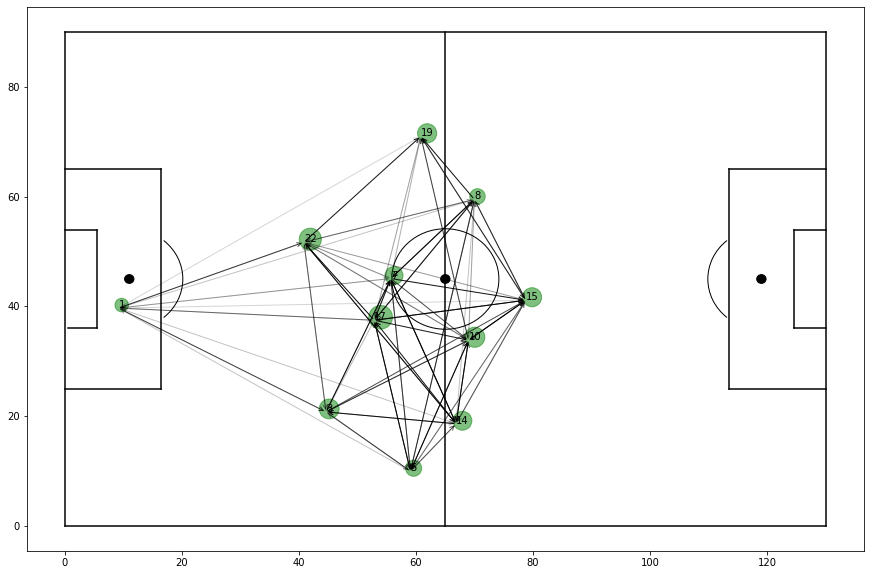

In [95]:
def get_team_avg(df, lineup):
    dic = dict()
    for player in lineup["lineup"]:
        name = player["player"]["name"]
        jersey = player["jersey_number"]
        avg, n = get_avg_pos(df, name)
        dic[name] = { "avg_pos" : avg, "n_touch": n, "jersey": jersey}
        # plt.plot(dic[name]["avg_pos"][0], dic[name]["avg_pos"][1], "o", color="green")
        
    return dic


def refine_tc(circuits):
    res = {}
    for link in circuits:
        tupl = tuple(link)
        if tupl not in res.keys():
            res[tupl] = 0
        res[tupl] += 1
    return res


def get_team_circuits(df, lineup) -> dict:
    res = []
    for player in lineup["lineup"]:
        name = player["player"]["name"]
        circuit = get_circuit(df, name)
        res = res + circuit
        
    return refine_tc(res)


FACTOR = 4

def get_sizes(positions):
    summ = 0
    for k, v in positions.items():
        summ += v["n_touch"]
    for k, v in positions.items():
        v["n_touch"] = v["n_touch"] * FACTOR / summ
    
    return positions
        

def plot_avg_map(positions) -> dict:
    positions = get_sizes(positions)
    for name, v in positions.items():
        avg_pos = v["avg_pos"]
        nb_t = v["n_touch"]
        jersey = v["jersey"]
        bbox = dict(facecolor='green', edgecolor='green', boxstyle=f'circle,pad={nb_t}', alpha=0.5)
        obj = plt.text(avg_pos[0], avg_pos[1], jersey, color="black", bbox=bbox)
        
        positions[name]["obj"] = obj
    
    return positions
    
IDK = 100
        
def plot_circuits(df, team, positions):
    circuits = get_team_circuits(df, team)
    total = sum([x for x in circuits.values()])
    for tupl, number in circuits.items():
        src, dst = tupl[0], tupl[1]
        if src in positions.keys() and dst in positions.keys():
            pos_src, pos_dst = positions[src]["avg_pos"], positions[dst]["avg_pos"]
            width = number / total
            plt.annotate("", xy=pos_dst, xytext=pos_src, arrowprops=dict(arrowstyle='->, head_width=0.2', facecolor='red',  \
                                                                         alpha=width*IDK), \
                         textcoords='data')
    
        
create_pitch()
positions = get_team_avg(df, home)
positions = plot_avg_map(positions)
plot_circuits(df, home, positions)

In [68]:
circuits = get_team_circuits(df, home)
circuits

{('Eiji Kawashima', 'Makoto Hasebe'): 1,
 ('Eiji Kawashima', 'Maya Yoshida'): 3,
 ('Eiji Kawashima', 'Hiroki Sakai'): 5,
 ('Eiji Kawashima', 'Yūya Ōsako'): 5,
 ('Eiji Kawashima', 'Gen Shōji'): 3,
 ('Eiji Kawashima', 'Takashi Inui'): 1,
 ('Eiji Kawashima', 'Genki Haraguchi'): 1,
 ('Eiji Kawashima', 'Gaku Shibasaki'): 1,
 ('Eiji Kawashima', 'Shinji Okazaki'): 1,
 ('Eiji Kawashima', 'Keisuke Honda'): 2,
 ('Hiroki Sakai', 'Gaku Shibasaki'): 5,
 ('Hiroki Sakai', 'Genki Haraguchi'): 13,
 ('Hiroki Sakai', 'Shinji Kagawa'): 5,
 ('Hiroki Sakai', 'Yūya Ōsako'): 3,
 ('Hiroki Sakai', 'Maya Yoshida'): 5,
 ('Hiroki Sakai', 'Makoto Hasebe'): 1,
 ('Hiroki Sakai', 'Keisuke Honda'): 3,
 ('Maya Yoshida', 'Gen Shōji'): 15,
 ('Maya Yoshida', 'Takashi Inui'): 4,
 ('Maya Yoshida', 'Hiroki Sakai'): 8,
 ('Maya Yoshida', 'Gaku Shibasaki'): 9,
 ('Maya Yoshida', 'Yūya Ōsako'): 6,
 ('Maya Yoshida', 'Makoto Hasebe'): 13,
 ('Maya Yoshida', 'Genki Haraguchi'): 1,
 ('Maya Yoshida', 'Shinji Kagawa'): 5,
 ('Maya Yoshida